In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../software')

In [87]:

import pandas
import seaborn
import numpy

from analysis import load_files

In [88]:

data = load_files('../data/one')
print(data.shape)
data.head(5)

(1840, 23)


,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,filename,experiment,lux,colortemp
0,1571,5773,7593,1333,2863,7591,1263,1795,7594,1572,...,2864,7593,1264,1795,7595,0,one_2500k_309lux.npy,one,309,2500
1,5034,1670,17984,2032,7307,17984,5959,1750,17984,5041,...,7308,17977,5961,1752,17979,1,one_2500k_309lux.npy,one,309,2500
2,5773,7592,1334,2862,7594,1263,1794,7593,1573,5779,...,7597,1263,1793,7595,1572,2,one_2500k_309lux.npy,one,309,2500
3,1670,17984,2032,7308,17980,5962,1750,17984,5041,1672,...,17984,5961,1751,17980,5039,3,one_2500k_309lux.npy,one,309,2500
4,7591,1333,2863,7594,1264,1795,7588,1572,5777,7597,...,1264,1795,7592,1572,5777,4,one_2500k_309lux.npy,one,309,2500


In [89]:
avg = data.groupby(['filename']).agg('median', numeric_only=True)
avg.head()

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_VIS2_BR,ch_F1,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,1207.0,1361.5,1527.0,883.0,1362.0,1527.0,1362.0,883.0,1527.5,1205.5,...,1527.0,882.5,1362.5,1528.0,1362.0,883.0,1526.5,9.5,100.0,2500.0
one_2500k_1lux.npy,11.0,12.0,13.0,10.5,12.0,13.0,12.0,10.5,13.5,11.0,...,13.0,10.5,12.0,13.0,12.0,10.5,13.0,9.5,1.0,2500.0
one_2500k_204lux.npy,2750.5,3030.0,3344.0,2084.0,3029.0,3342.0,3028.5,2083.0,3345.5,2750.5,...,3346.0,2085.0,3032.5,3342.5,3031.0,2084.5,3346.0,9.5,204.0,2500.0
one_2500k_309lux.npy,5034.0,5405.0,5868.5,3951.0,5406.0,5867.5,5404.0,3952.0,5868.5,5040.0,...,5870.0,3950.5,5406.0,5867.0,5408.5,3951.0,5871.0,9.5,309.0,2500.0
one_2500k_408lux.npy,7322.0,7756.0,8354.0,5822.0,7756.0,8353.5,7758.5,5827.0,8354.0,7320.0,...,8356.0,5825.5,7759.5,8354.0,7761.0,5827.5,8357.0,9.5,408.0,2500.0


['ch_FZ', 'ch_FY', 'ch_FXL', 'ch_F2', 'ch_F3', 'ch_F4', 'ch_F6', 'ch_F1', 'ch_F7', 'ch_F8', 'ch_F5']
Fitting 5 folds for each of 25 candidates, totalling 125 fits


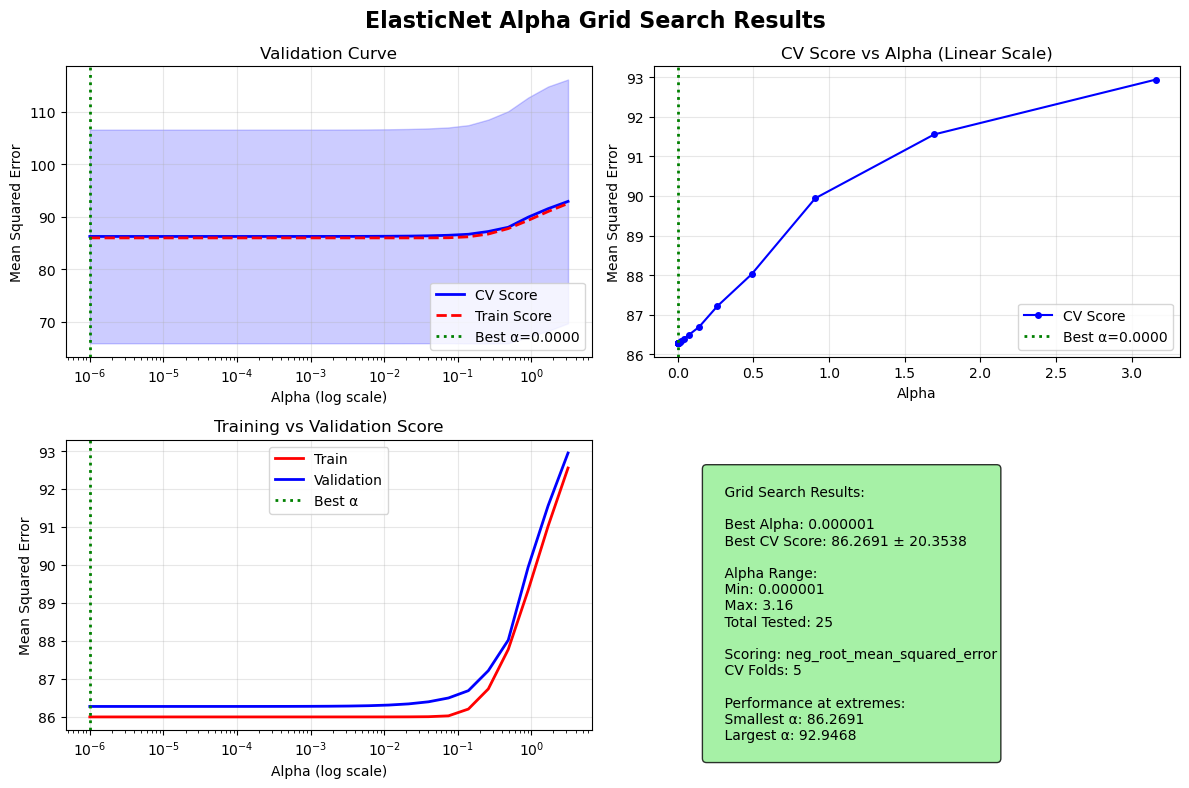

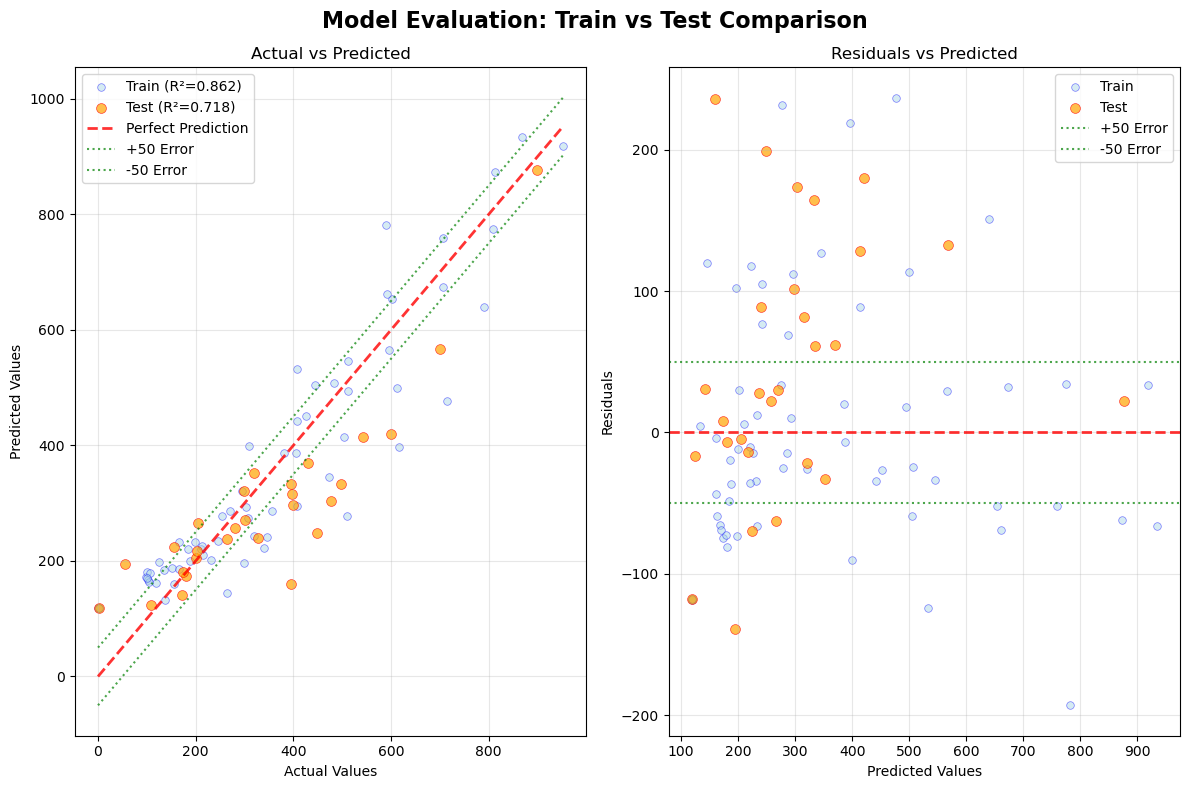


Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.8615       0.7185       0.1430      
RMSE                      86.3173      103.3238     17.0065     
Mean Absolute Error       66.7498      79.7953      13.0455     
Sample Size               64           28          


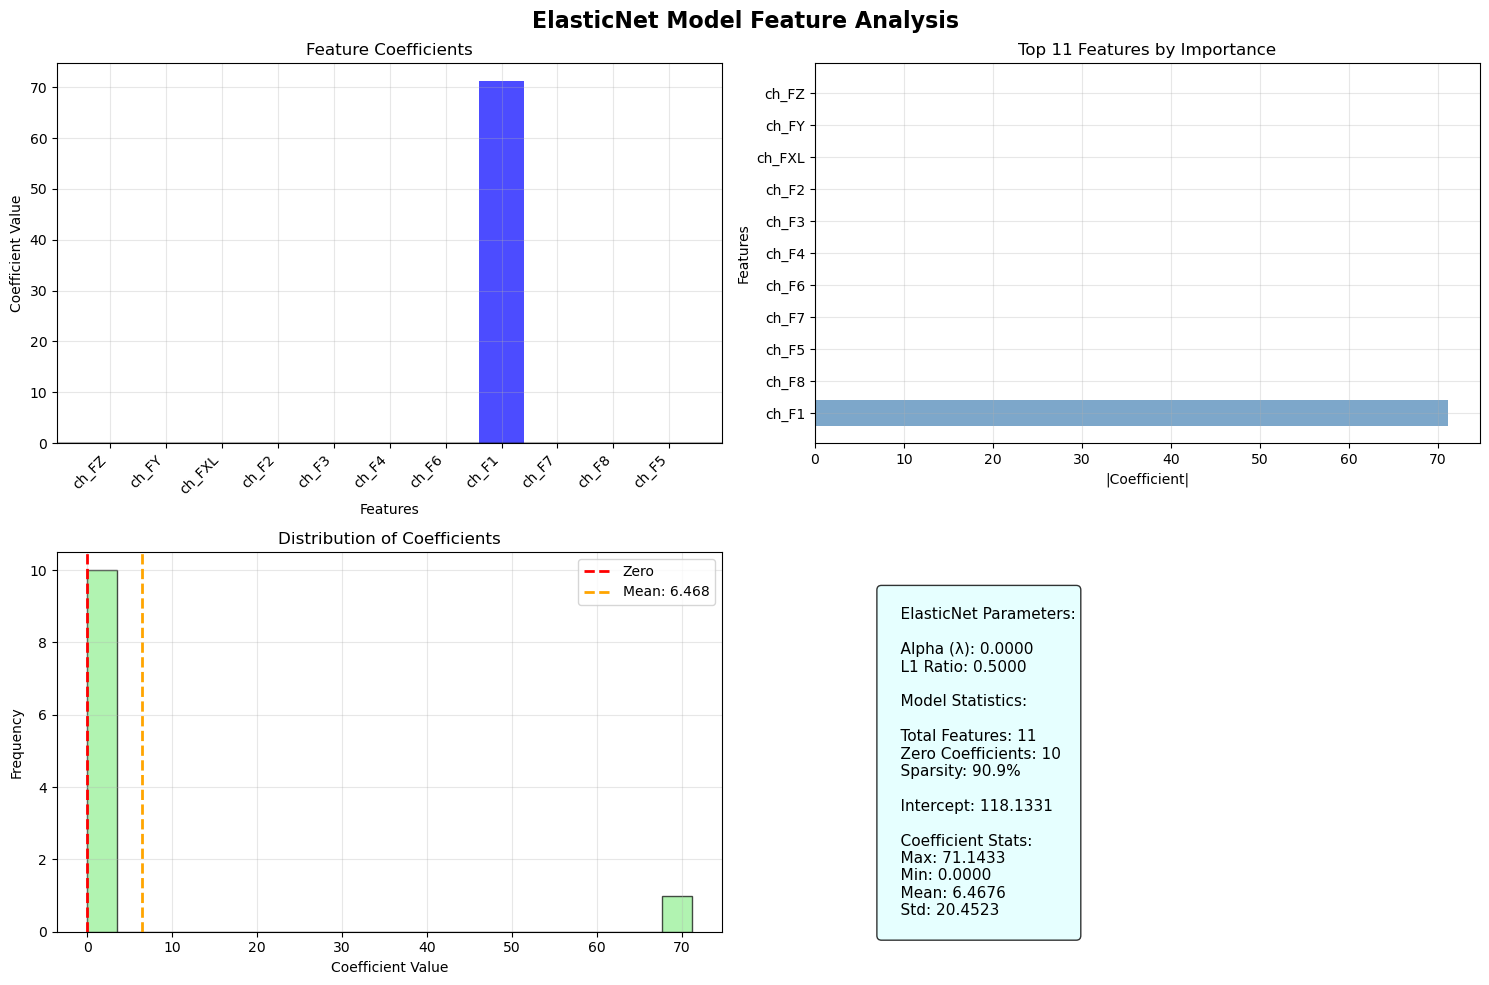

NameError: name 'scores' is not defined

In [126]:

from train import create_pipeline, evaluate_pipeline

features = [ c for c in data.columns if 'ch_F' in c]
print(features)
#sub = avg[avg.colortemp == 2500]
sub = avg.copy()
X = sub[features] / 1000.0
y = sub['lux']

est = create_pipeline()
scores = evaluate_pipeline(est, X, y)

scores    

Wrote one_averaged.png


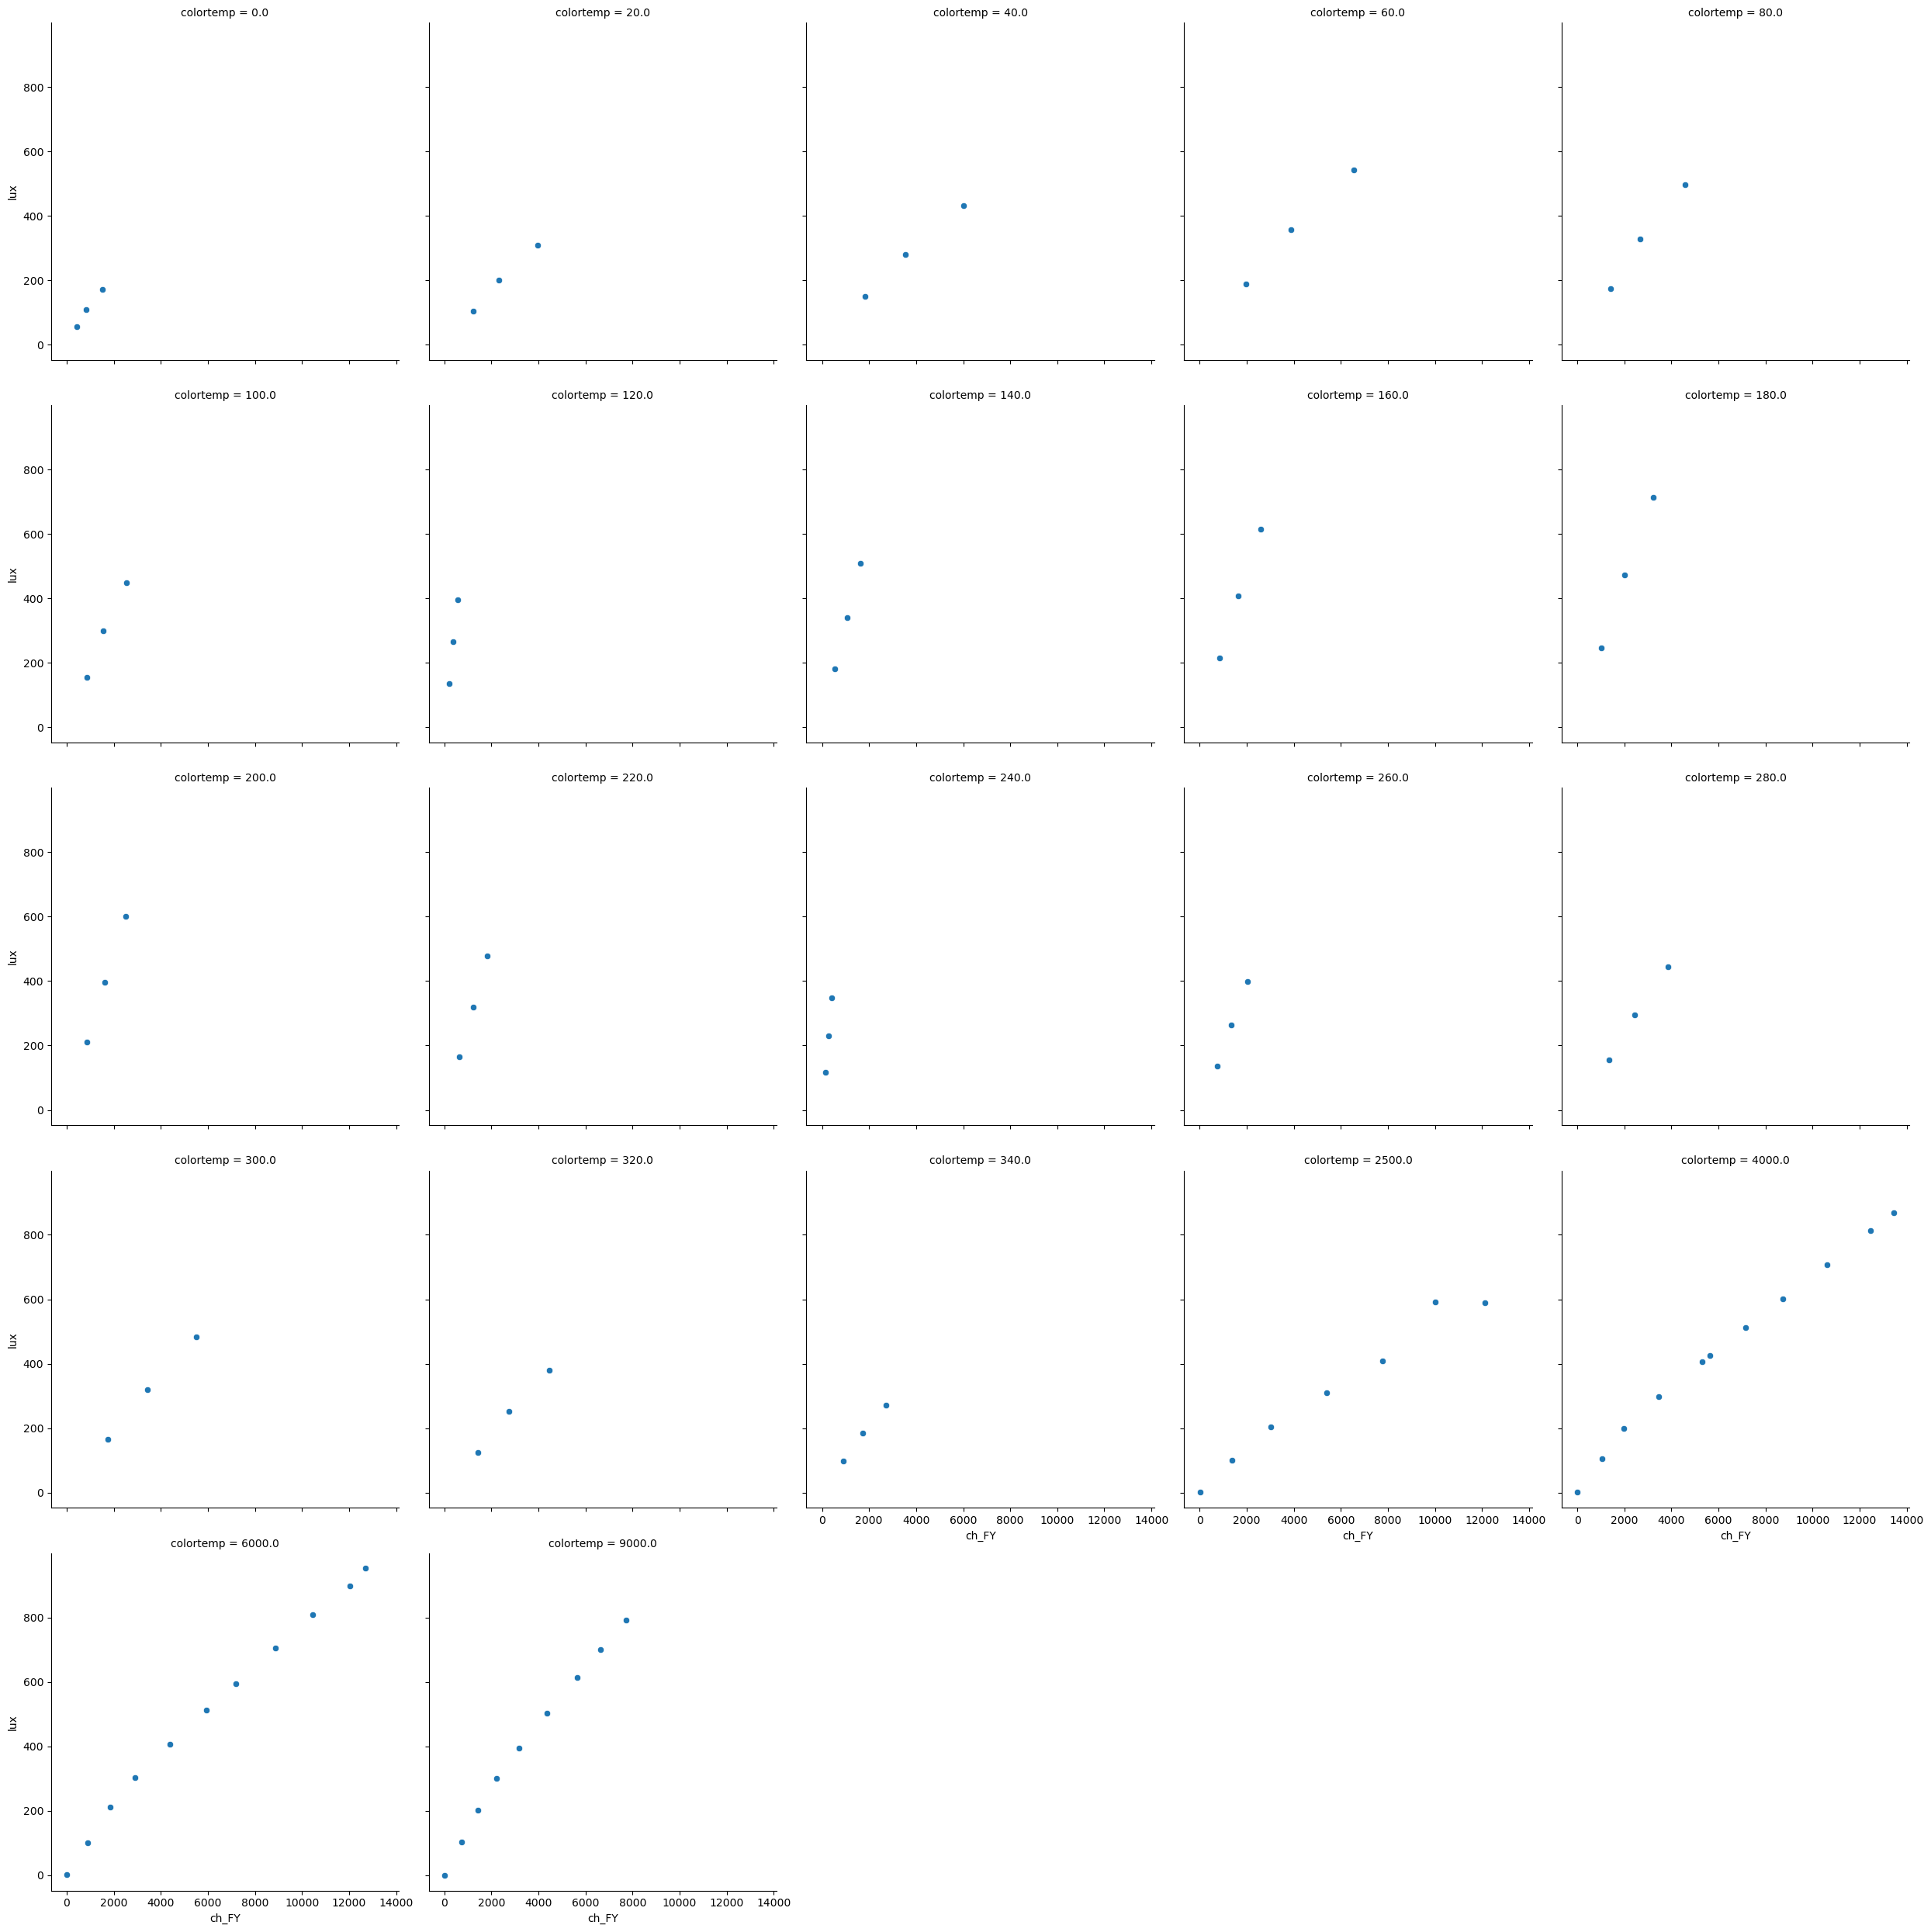

In [124]:
g = seaborn.relplot(data=avg, x='ch_FY', y='lux', col='colortemp', col_wrap=5)
fig = g.figure
plot_path = 'one_averaged.png'
fig.savefig(plot_path)
print('Wrote', plot_path)